# Fine-tune Gemma Model for Language Translation



### Objective



Imagine two 13-year-old boys—one from Kerala and the other from America—meeting at school, but they can't understand each other because they speak different languages! Our mission? To train the **Gemma 2B model** to help them chat away like best buddies by translating **English to Malayalam** and **Mayalam to English**. By the end of this project, we'll have a model that makes language barriers disappear, turning awkward silences into fun conversations, one translation at a time! Let's make language learning fun and easy for these two new friends!



### Gemma







Gemma is a family of lightweight, state-of-the-art open models from Google, built from the same research and technology used to create the Gemini models. These models are text-to-text, decoder-only large language models available in English, with open weights for both pre-trained and instruction-tuned variants.







Gemma models are highly suitable for various text generation tasks, such as question answering, summarization, and reasoning. Their relatively small size makes deployment possible in environments with limited resources, including laptops, desktops, or personal cloud infrastructure. This democratizes access to advanced AI models and encourages innovation across diverse applications.







---







### Model Information







- **Preset name**: `gemma2_instruct_2b_en`



- **Parameters**: 2 Billion



- **Layers**: 26







---

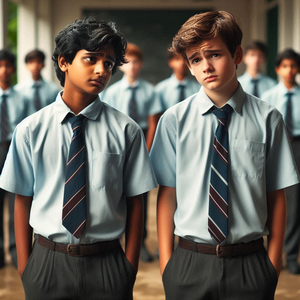

# Setup







 To get started with fine-tuning the Gemma model on Kaggle, follow these steps:







1. **Access the Model on Kaggle**  



   - Visit the model page on Kaggle: [Gemma Model on Kaggle](https://www.kaggle.com/models/keras/gemma2).







2. **Select GPU Accelerator**  



   - Navigate to the **Settings** section in the top toolbar on Kaggle.



   - Under **Accelerator**, choose `GPU P100` to leverage enhanced processing power for training.

## Import Packages







This project requires the following packages: `os` for configuring environment settings to optimize backend usage in Keras; `keras_nlp` and `keras` for natural language processing and model handling; `pandas` for efficient dataset management and manipulation; `time` for tracking and managing time-based operations; and `tqdm` for progress bar display in iterative processes, helping to track processing time effectively.


In [1]:
import os

import keras_nlp

import keras

import pandas as pd

import time

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

### Configure Environment for JAX Backend







Setting `KERAS_BACKEND` to `"jax"` enables the JAX backend for Keras, enhancing model performance. Adjusting `XLA_PYTHON_CLIENT_MEM_FRACTION` to `1.00` helps avoid memory fragmentation, ensuring efficient memory allocation during processing.


In [2]:
os.environ["KERAS_BACKEND"] = "jax"

# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

### Load Data







The dataset used for training the model is sourced from various reputable platforms, including [ORPUS](https://opus.nlpl.eu/) and [Tatoeba](https://tatoeba.org/en/), which provide a diverse collection of parallel corpora for language translation tasks.


In [3]:
data = pd.read_csv(r"/kaggle/input/lang-trans-eng-malayalam/eng-malayalam-trans.csv", on_bad_lines="skip")

# Split data into training and testing sets, with 1150 samples for training

train_data, test_data = train_test_split(data, train_size=250, shuffle=False)

# Extract test input (English) and output (Malayalam)

test_input, test_output = test_data['english'], test_data['malayalam']

## Training Configurations







In this step, we define the configuration parameters necessary for training the model. These parameters include:







- **token_limit**: Sets the maximum number of tokens allowed for each input sequence (256 tokens).



- **lora_name**: The name for the LoRA (Low-Rank Adaptation) model, set to `"eng_mala_translator"`.



- **lora_rank**: Defines the rank for LoRA, set to 4.



- **lr_value**: The learning rate for training, set at `1e-4`.



- **train_epoch**: The number of epochs for training, set to 2.



- **model_id**: Specifies the model identifier for the base model, set to `"gemma2_instruct_2b_en"`.







These configurations control the training process and help tune the model for optimal performance.


In [4]:
# Training Configurations
class Config:

    token_limit = 256
    lora_name = "eng_mala_translator"
    lora_rank = 4
    lr_value = 1e-4
    train_epoch = 2
    model_id = "gemma2_instruct_2b_en"

# Load Model & Tokenizer







Initialize the tokenizer and model using the configuration settings. The `GemmaTokenizer` is loaded from the specified preset, which corresponds to the `gemma2_instruct_2b_en` model in the configuration. The `GemmaCausalLM` model is also loaded from the same preset. Once the model is initialized, we use the `summary()` method to inspect the model’s architecture, including the number of layers and parameters, providing insight into the model’s structure before proceeding with training.


In [5]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(Config.model_id)

gemma = keras_nlp.models.GemmaCausalLM.from_preset(Config.model_id)

gemma.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

# Training Data







## Instruction for Prompting Instruction-Tuned Models







Instruction-tuned versions (suffixed with `instruct`) should be prompted with examples that precisely match the training data. Specifically, you must alternate user and assistant turns that begin and end with special tokens. New lines do matter. Model responses will additionally have an `<eos>` token.







For more information related to the model, including details on fine-tuning and usage, refer to the [Gemma2 Model on Kaggle](https://www.kaggle.com/models/keras/gemma2).







See the following for an example:







```python



start_of_turn_user = "<start_of_turn>user\n"



start_of_turn_model = "<start_of_turn>model\n"



end_of_turn = "<end_of_turn>\n"



prompt = start_of_turn_user + "You are a friendly assistant. Say hi." + \



    end_of_turn + start_of_turn_model + "Hi! How can I assist you today?" + \



    end_of_turn + "<eos>"


## Preparing Training Data







In this step, we are preparing the training data by processing the dataset. Each item from the dataset is formatted to include both the user input and the system's response, with appropriate special tokens (`<start_of_turn>`, `<end_of_turn>`). The dataset consists of English input and Malayalam output, where the English text is considered as the user prompt and the Malayalam text as the system's response.







To ensure that the training data fits within the model's token limits, we filter out items that exceed the token limit. For this example, a token limit of **256** tokens is used. Only those examples that have a token count less than this limit are included in the final training dataset.







### Key values used in this step:



* **Token limit**: 256 tokens (ensures data does not exceed model's input capacity)



* **Dataset fields**:



  * **English text** (User input)



  * **Malayalam text** (System output)







This approach helps in creating a clean and efficient dataset, adhering to the token constraints, and optimizing the fine-tuning process for better performance.


In [6]:
from tqdm import tqdm

# Predefine the item format to avoid redundant computation in the loop
item_template = "<start_of_turn>user\n{}\n<end_of_turn>\n<start_of_turn>system\n{}\n<end_of_turn>"

forward = []

backward = []


# Use tqdm for progress tracking in tokenization

for _, row in tqdm(train_data.iterrows(), desc='Tokenizing dataset'):

    english_text = row['english']

    malayalam_text = row['malayalam']

    # Format item once for both forward and backward, reducing tokenizer calls

    forward_item = item_template.format(english_text, malayalam_text)

    backward_item = item_template.format(malayalam_text, english_text)

    # Check token limit only once per item

    if len(tokenizer(forward_item)) < Config.token_limit:

        forward.append(forward_item)

        backward.append(backward_item)

# Output results

print(f"Forward length: {len(forward)}")

print("Examples from forward list:")

for example in forward[:3]:  # Print the first three examples

    print(example)

print(f"Backward length: {len(forward)}")

print("Examples from backward list:")

for example_2 in backward[:3]:  # Print the first three examples

    print(example_2)

Tokenizing dataset: 250it [00:00, 576.40it/s]

Forward length: 250
Examples from forward list:
<start_of_turn>user
Congratulations!
<end_of_turn>
<start_of_turn>system
അഭിനന്ദനങ്ങള്‍
<end_of_turn>
<start_of_turn>user
Nobody understands me.
<end_of_turn>
<start_of_turn>system
ആരും എന്നെ മനസ്സിലാക്കുന്നില്ല.
<end_of_turn>
<start_of_turn>user
You are a coward!
<end_of_turn>
<start_of_turn>system
നീ ഒരു പേടിത്തൊണ്ടനാണ്
<end_of_turn>
Backward length: 250
Examples from backward list:
<start_of_turn>user
അഭിനന്ദനങ്ങള്‍
<end_of_turn>
<start_of_turn>system
Congratulations!
<end_of_turn>
<start_of_turn>user
ആരും എന്നെ മനസ്സിലാക്കുന്നില്ല.
<end_of_turn>
<start_of_turn>system
Nobody understands me.
<end_of_turn>
<start_of_turn>user
നീ ഒരു പേടിത്തൊണ്ടനാണ്
<end_of_turn>
<start_of_turn>system
You are a coward!
<end_of_turn>


In [7]:
data = forward+backward

len(data)

500

In [8]:
import time

def text_gen(prompt):

    start_time = time.time()

    input_text = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"

    output = gemma.generate(input_text, max_length=Config.token_limit)

    print("\nGemma output:")

    print(output)

    print(f"TOTAL TIME ELAPSED: {time.time() - start_time:.2f}s")

    return output.strip()

# LoRA Fine-tuning







To enhance the model's performance, fine-tune the model with Low-Rank Adaptation (LoRA) using a suitable dataset.







The LoRA rank determines the dimensionality of the trainable matrices added to the model's original weights. It controls the expressiveness and precision of fine-tuning.







- **Higher rank**: Allows more detailed changes but introduces more trainable parameters.



- **Lower rank**: Reduces computational overhead but might lead to less precise adaptation.







In this project, we are using a LoRA rank of **4**. This is computationally efficient for experimentation and helps reduce the number of trainable parameters significantly, from **2.6 billion** to just **2.9 million**. This makes the model more lightweight and faster to train. After training, we will evaluate the model and can consider adjusting the rank if further improvements ar needed.







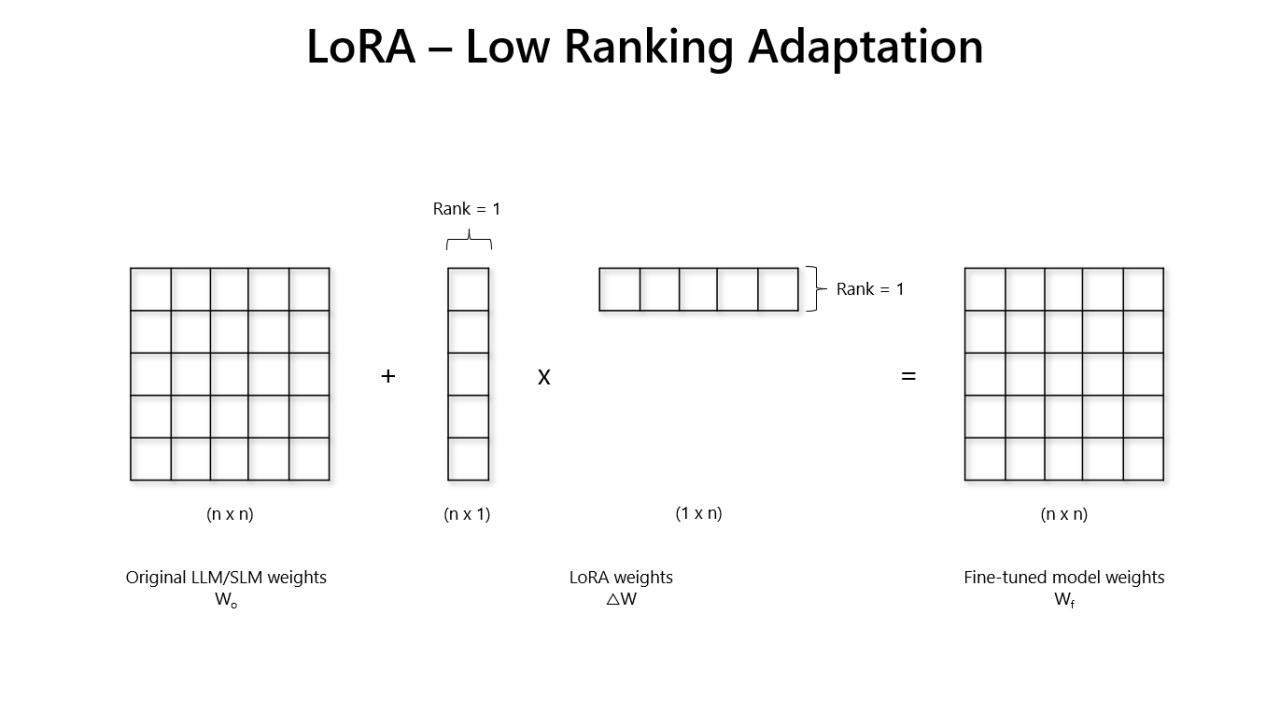

In [9]:
gemma.backbone.enable_lora(rank=Config.lora_rank)

gemma.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

## Optimize and Compile Model







The input sequence length is limited to 256 tokens to manage memory usage efficiently. The **AdamW optimizer** is chosen, with a learning rate of `1e-4` and a weight decay of `0.01`, to help regularize the model during training. Bias and scale terms are excluded from weight decay to prevent unnecessary penalization of these less critical parameters. Finally, the model is compiled using **Sparse Categorical Crossentropy** as the loss function and **Sparse Categorical Accuracy** as the evaluation metric, making it well-suited for the translation task.


In [10]:
# Limit the input sequence length (to control memory usage).
gemma.preprocessor.sequence_length = Config.token_limit


# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(

    learning_rate=Config.lr_value,

    weight_decay=0.01
)


# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])


gemma.compile(

    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),

    optimizer=optimizer,

    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()]

)

## Model fitting







A custom callback class is created to save the LoRA weights of the model at the end of each epoch. The `on_epoch_end` method saves the model's LoRA weights to a file with a dynamic name based on the LoRA rank and model name. The callback also evaluates the model by generating text for various input sentences, ensuring that the model is performing well after each epoch. The model is then trained using the `fit` method with the specified number of epochs and batch size, and the custom callback is used to monitor the model's progress during training.







Key actions:



- Saving the LoRA weights after each epoch.



- Text generation for evaluation after each epoch.



- Training the model with a custom callback to monitor performance.

In [11]:
class CustomCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):

        model_name = f"/kaggle/working/{Config.lora_name}_{Config.lora_rank}_last.lora.h5"

        gemma.backbone.save_lora_weights(model_name)

        # Evaluate
        text_gen("ആരും എന്നെ മനസ്സിലാക്കുന്നില്ല")

        text_gen("നീ ഒരു പേടിത്തൊണ്ടനാണ്")

        text_gen("My name is Nihal")

        text_gen("You are a coward!")

history = gemma.fit(data, epochs=Config.train_epoch, batch_size=1, callbacks=[CustomCallback()])

Epoch 1/2


I0000 00:00:1731957442.541986      66 service.cc:145] XLA service 0x7b5e1c0031d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731957442.542041      66 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1731957447.744645      66 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1731957467.084777      66 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 436 bytes spill stores, 508 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 68 bytes spill stores, 116 bytes spill loads
ptxas warning : Regi

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 0.4716 - sparse_categorical_accuracy: 0.5693
Gemma output:
<start_of_turn>user
ആരും എന്നെ മനസ്സിലാക്കുന്നില്ല<end_of_turn>
<start_of_turn>model
Nobody understands me.
<end_of_turn>
TOTAL TIME ELAPSED: 23.77s

Gemma output:
<start_of_turn>user
നീ ഒരു പേടിത്തൊണ്ടനാണ്<end_of_turn>
<start_of_turn>model
You're a bit of a slob.
<end_of_turn>
TOTAL TIME ELAPSED: 0.63s

Gemma output:
<start_of_turn>user
My name is Nihal<end_of_turn>
<start_of_turn>model
എനിക്ക് നീഹാൽ പേര്.
<end_of_turn>
TOTAL TIME ELAPSED: 0.74s

Gemma output:
<start_of_turn>user
You are a coward!<end_of_turn>
<start_of_turn>model
എനിക്ക് ഈ കാര്യം അനുഭവിക്കാൻ പറ്റില്ല.
<end_of_turn>
TOTAL TIME ELAPSED: 1.03s
500/500 ━━━━━━━━━━━━━━━━━━━━ 307s 475ms/step - loss: 0.4713 - sparse_categorical_accuracy: 0.5694
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 0.2253 - sparse_categorical_accuracy: 0.7097
Gemma output:
<start_of_turn>user
ആരും എന്നെ മനസ്സിലാക്കുന്നില്ല<end_

# Model Evaluation

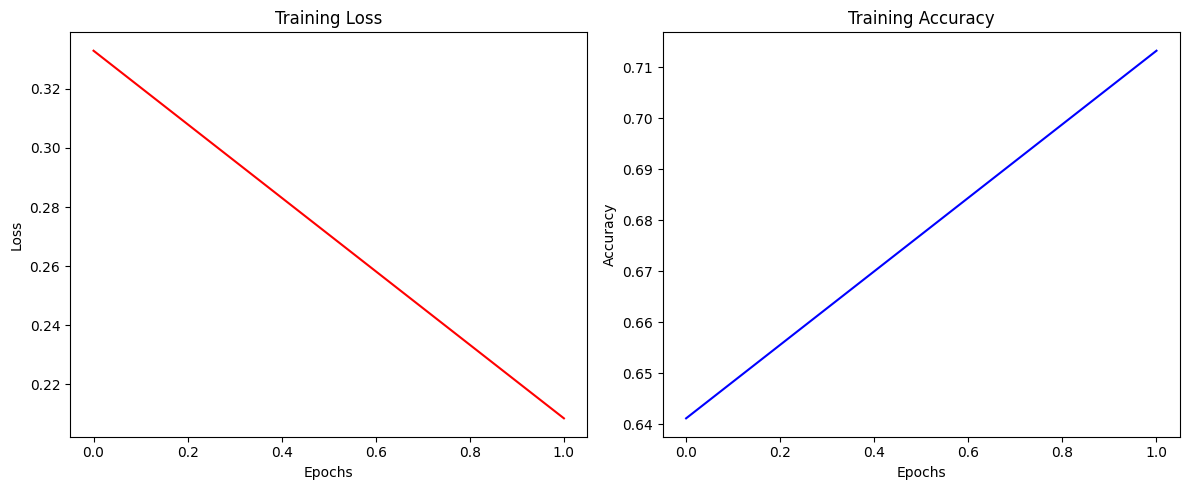

In [12]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss
ax1.plot(history.history['loss'], color='red')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

# Plot accuracy
ax2.plot(history.history['sparse_categorical_accuracy'], color='blue')
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

# Show the plots
plt.tight_layout()
plt.show()

In [13]:
import re

def gen(prompt):

    start_time = time.time()

    # Prepare the input text for the model

    input_text = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"

    # Generate the output from the model

    output = gemma.generate(input_text, max_length=Config.token_limit)

    # Use regular expression to extract the Malayalam text (after '<start_of_turn>model' and before '<end_of_turn>')

    malayalam_output = re.search(r'<start_of_turn>model\n(.*?)<end_of_turn>', output, re.DOTALL)

    # If the Malayalam text is found, return it, otherwise return None

    if malayalam_output:

        return malayalam_output.group(1).strip()  # Extract and remove leading/trailing whitespaces

    else:

        return None  # If no match is found

In [14]:
#from IPython.display import FileLink


#FileLink(r'eng_mala_translator_4_last.lora.h5')

In [15]:
test_data = test_data[:10]

test_input, test_output = test_data['english'], test_data['malayalam']

mala_input, eng_output = test_data['malayalam'], test_data['english']

In [16]:
print("Model Predictions:-")

for i in test_input:

    print(gen(i))

Model Predictions:-
ഞാൻ അവരെ ഈ റൂം ਛകിച്ചു.
ഞാൻ അവളുടെ ഓർമ്മപ്പെടുത്തുന്നത് കാണാൻ കഴിയുന്നില്ല.
ഞാൻ അവളുടെ τηലിഫോൺ നമ്പറും എന്നു.
ഞാൻ 매 രാത്രി 6 മണിയോടെ ഉ wst ഓണാണ്.
None
ഞാൻ ജീവിച്ചു കാണാൻ ആഗ്രഹിക്കുന്നു.
എനിക്ക് തിരിച്ചു വരാം.
ഞാൻ രാത്രി വരെ കിടക്കുന്നത് പരിചിതമായിട്ടില്ല.
ഞാൻ ഭര്‍ത്താവും ഞാനും കൂടെയാണ് താമസിക്കുന്നത്.
ഞാൻ അതുപോലും പോയിട്ടുണ്ട്.


In [17]:
print("ORIGINAL:- ")

for _ in test_output:

    print(_)

ORIGINAL:- 
ഞാൻ അവരോട് മുറി വിട്ട് പോകാൻ കല്പിച്ചു.
അവള്‍ പറഞ്ഞതെന്താണെന്ന് എനിക്ക് മനസ്സിലാക്കാന്‍ സാധിക്കുന്നില്ല.
ഞാൻ അവളുടെ ഫോൺ നമ്പർ എഴുതിയെടുത്തു.
ഞാൻ എന്നും രാവിലെ ആറ് മണിക്ക് എഴുന്നേൽക്കും.
എനിക്ക് ടികറ്റ് സൗജന്യമായി ലഭിച്ചു.
എനിക്ക് ജീവിക്കണം.
ഞാൻ തിരിച്ചുവരും.
എനിക്ക് രാത്രി വൈകിയിരുന്നു ശീലമില്ല.
ഞാൻ എന്റെ മാതാപിതാക്കളുടെ കൂടെയാണ് ജീവിക്കുന്നത്.
ഞാനും പോയി.


In [18]:
print("Model Precition:-")

pred = []
for k in mala_input:
    word = gen(k)
    pred.append(word)
    print(word)

Model Precition:-
I told them to leave.
I don't understand what she said.
I wrote down her phone number.
I get up at 6 o'clock in the morning.
I got a free ticket.
You have to live.
I'll be back.
I'm not used to getting up late at night.
I live with my parents.
I'll go too.


In [19]:
print("Original:-")

for _ in eng_output:
    print(_)

Original:-
I ordered them to leave the room.
I can't make out what she said.
I wrote down her phone number.
I get up at six every morning.
I got the ticket for free.
I want to live.
I'll come back.
I am not used to sitting up late at night.
I live with my parents.
I also went.


### BLEU Score Evaluation for Translation



1. **Import Libraries**  

   - Import `nltk` and BLEU scoring functions.



2. **Download Tokenizer**  

   - Download `punkt` for tokenization.



3. **Define Evaluation Function**  

   - `evaluate_translation_bleu(predictions, references)` computes BLEU scores.

     - **Inputs**:

       - `predictions`: Model translations.

       - `references`: Lists of reference translations.

     - **Outputs**:

       - `sentence_bleu_scores`: BLEU for each sentence.

       - `avg_sentence_bleu`: Average BLEU score.

       - `corpus_bleu_score`: Overall corpus BLEU score.



4. **Evaluate Translations**  

   - Run `evaluate_translation_bleu(pred, test_output)`.


In [20]:
import nltk

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

# Ensure nltk resources are downloaded if you haven't already
nltk.download('punkt')

def evaluate_translation_bleu(predictions, references):

    tokenized_predictions = [nltk.word_tokenize(pred) for pred in predictions]

    tokenized_references = [[nltk.word_tokenize(ref) for ref in refs] for refs in references]

    sentence_bleu_scores = [

        sentence_bleu(refs, pred) for pred, refs in zip(tokenized_predictions, tokenized_references)

    ]

    corpus_bleu_score = corpus_bleu(tokenized_references, tokenized_predictions)

    avg_sentence_bleu = sum(sentence_bleu_scores) / len(sentence_bleu_scores)

    return sentence_bleu_scores, avg_sentence_bleu, corpus_bleu_score

# Evaluate BLEU scores
sentence_bleu_scores, avg_sentence_bleu, corpus_bleu_score = evaluate_translation_bleu(pred, eng_output)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [21]:
print("Sentence_bleu_scores:- ",sentence_bleu_scores)

print("Avg_bleu_scores:- ",avg_sentence_bleu)

print("Corpus_bleu_scores:- ",corpus_bleu_score)

Sentence_bleu_scores:-  [0.7598356856515925, 0.7071067811865476, 0.7311104457090247, 0.668740304976422, 0.7598356856515925, 0.668740304976422, 0.7952707287670506, 0.6529942057256104, 0.7598356856515925, 0.7952707287670506]
Avg_bleu_scores:-  0.7298740557062906
Corpus_bleu_scores:-  0.7243961401283154


### Visualize BLEU Scores



- **Plot Sentence BLEU Scores**: Display individual BLEU scores as a bar chart.

- **Add Reference Lines**: Show `avg_sentence_bleu` (orange dashed) and `corpus_bleu_score` (red solid) as reference lines.

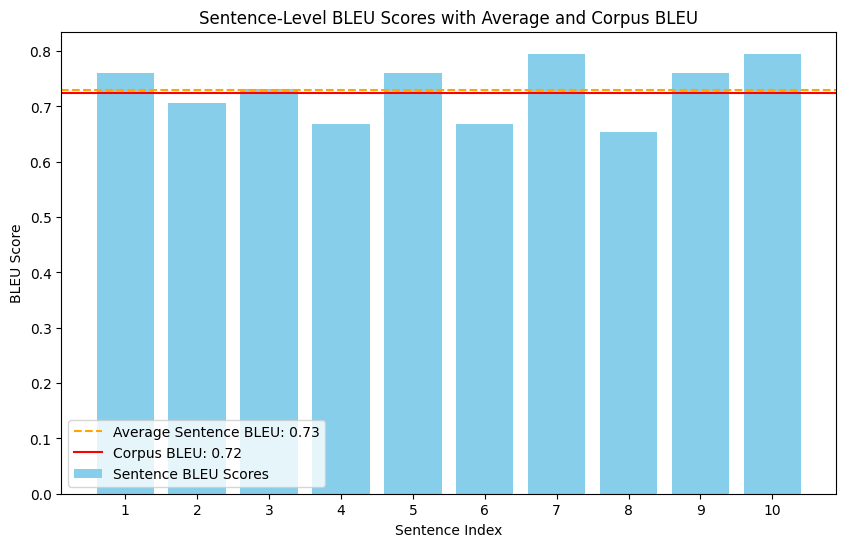

In [22]:
# Visualize BLEU scores

plt.figure(figsize=(10, 6))

# Bar chart for individual sentence BLEU scores

plt.bar(range(1, len(sentence_bleu_scores) + 1), sentence_bleu_scores, color='skyblue', label='Sentence BLEU Scores')

# Average BLEU score as a horizontal line

plt.axhline(y=avg_sentence_bleu, color='orange', linestyle='--', label=f'Average Sentence BLEU: {avg_sentence_bleu:.2f}')

plt.axhline(y=corpus_bleu_score, color='red', linestyle='-', label=f'Corpus BLEU: {corpus_bleu_score:.2f}')

# Labeling
plt.xlabel('Sentence Index')

plt.ylabel('BLEU Score')

plt.title('Sentence-Level BLEU Scores with Average and Corpus BLEU')

plt.legend()

plt.xticks(range(1, len(sentence_bleu_scores) + 1))

# Show the plot
plt.show()

# Model Inference

In [23]:
# Example Code for Load LoRA
#import os

#import keras

#import keras_nlp

#gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma2_instruct_2b_en")

# Use the same LoRA rank that you trained

#gemma_lm.backbone.enable_lora(rank=4)

# Load pre-trained LoRA weights
#gemma_lm.backbone.load_lora_weights(f"/kaggle/input/bilingual-translation-english-malayalam/keras/default/1/eng_mala_translator_4_last.lora.h5")

In [24]:
import time


def our_model(prompt):

    start_time = time.time()

    input_text = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"

    output = gemma_lm.generate(input_text, max_length=Config.token_limit)

    print("\nGemma output:")

    print(output)

    print(f"TOTAL TIME ELAPSED: {time.time() - start_time:.2f}s")

    return output.strip()

In [25]:
#our_model("You are a coward")

# Conclusion



And there we have it—our language bridge is built! 🎉 Now, our two friends from Kerala and America can chat away without missing a beat. The Gemma 2B model has gone from a pile of data to a translation superhero, turning English into Malayalam and Malayalam back to English like a breeze. No more awkward silences or hand gestures—just endless stories, jokes, and laughter!



With this project, we’ve not only created a powerful translation tool but also proven that technology can bring people together, no matter where they’re from. So, here’s to more friendships, more learning, and a world where languages are no longer barriers but stepping stones to fun and understanding. On to the next adventure—who knows where our language skills will take us next? 🌏✌️


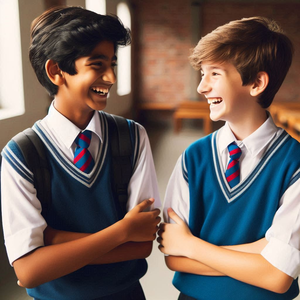